In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Dependencies

In [2]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.9 MB/s eta 0:00:00


In [ ]:
!pip install plotly

In [ ]:
!pip show plotly

Name: plotly
Version: 5.15.0
Summary: An open-source, interactive data visualization library for Python
Home-page: https://plotly.com/python/
Author: Chris P
Author-email: chris@plot.ly
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: packaging, tenacity
Required-by: cufflinks, datascience, geemap


In [ ]:
!pip install plotly --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 85.5 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0


In [3]:
pip install h5py

In [4]:
pip install torch

In [5]:
pip install numpy

In [ ]:
pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


#Pre-Processing

In [ ]:
import os

directory_path = '/content/drive/MyDrive/TNG graphs'

# Walk through the directory
for root, dirs, files in os.walk(directory_path):
    for file in files:
        # Print the path of each file
        print(os.path.join(root, file))


/content/drive/MyDrive/TNG graphs/549516subgraph_with_subfinddensity.pt
/content/drive/MyDrive/TNG graphs/537941subgraph_with_subfinddensity.pt
/content/drive/MyDrive/TNG graphs/509091subgraph_with_subfinddensity.pt


In [ ]:
import torch

file_paths = [
    '/content/drive/MyDrive/TNG graphs/549516subgraph_with_subfinddensity.pt',
    '/content/drive/MyDrive/TNG graphs/537941subgraph_with_subfinddensity.pt',
    '/content/drive/MyDrive/TNG graphs/509091subgraph_with_subfinddensity.pt',
]

# Loading the files into Python
loaded_files = []
for path in file_paths:
    loaded_file = torch.load(path)
    loaded_files.append(loaded_file)

In [ ]:
graph1_data = loaded_files[0]

In [ ]:
import torch
import h5py
import numpy as np
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

file_path = '/content/drive/MyDrive/TNG graphs/cutout_549516.hdf5'

with h5py.File(file_path, 'r') as file:
    part_type1 = file['PartType1']
    coordinates = part_type1['Coordinates'][:]
    subfind_density = part_type1['SubfindDensity'][:]
    subfind_dmdensity = part_type1['SubfindDMDensity'][:]

# Normalize the Coordinates for machine learning
scaler_coords = StandardScaler().fit(coordinates)
coordinates_normalized = scaler_coords.transform(coordinates)

# Normalize the SubfindDensity and SubfindDMDensity
scaler_density = StandardScaler().fit(subfind_density.reshape(-1, 1))
subfind_density_normalized = scaler_density.transform(subfind_density.reshape(-1, 1)).flatten()

scaler_dmdensity = StandardScaler().fit(subfind_dmdensity.reshape(-1, 1))
subfind_dmdensity_normalized = scaler_dmdensity.transform(subfind_dmdensity.reshape(-1, 1)).flatten()

# Input features
features_tensor = torch.tensor(coordinates_normalized, dtype=torch.float)

# Targets
targets_tensor = torch.tensor(np.vstack((subfind_density_normalized, subfind_dmdensity_normalized)).T, dtype=torch.float)

# Edges based on spatial proximity
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(coordinates_normalized)
distances, indices = nbrs.kneighbors(coordinates_normalized)

# Convert neighbor indices to edge index format expected by PyTorch Geometric
source_nodes = np.repeat(np.arange(indices.shape[0]), indices.shape[1])
target_nodes = indices.flatten()

edge_index = torch.tensor(np.vstack((source_nodes, target_nodes)), dtype=torch.long)

#Graph data object with coordinates as node features and densities as targets
graph_data = Data(x=features_tensor, edge_index=edge_index, y=targets_tensor)

save_path = '/content/drive/MyDrive/TNG graphs/549516subgraph_with_subfinddensity_subfinddmdensity22.pt'
torch.save(graph_data, save_path)

print(f"Graph saved successfully to {save_path}")

In [ ]:
features = graph1_data.x

x = features[:, 0].numpy()
y = features[:, 1].numpy()
z = features[:, 2].numpy()
subfind_density = features[:, 3].numpy()

# 3D Visualisation

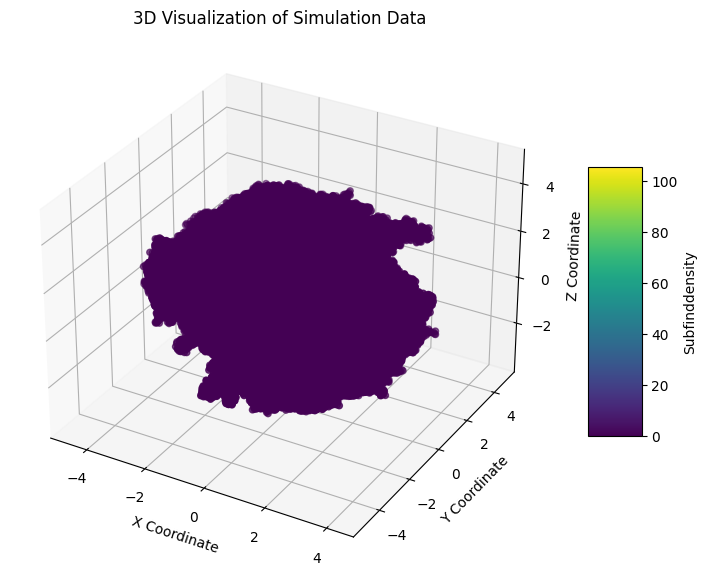

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(x, y, z, c=subfind_density, cmap='viridis')

color_bar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
color_bar.set_label('Subfinddensity')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')


ax.set_title('3D Visualization of Simulation Data')


plt.show()


In [ ]:
import torch
import plotly.graph_objects as go
import numpy as np

graph_data_path = '/content/drive/MyDrive/TNG graphs/549516subgraph_with_subfinddensity_subfinddmdensity.pt'

coordinates = graph_data.x[:, :3].numpy()
subfind_density_normalized = graph_data.x[:, -1].numpy()

density_threshold = np.percentile(subfind_density_normalized, 90)

high_density_indices = np.where(subfind_density_normalized >= density_threshold)[0]

coordinates_high_density = coordinates[high_density_indices]
subfind_density_high_density = subfind_density_normalized[high_density_indices]

# Normalize subfind_density for visualization
subfind_density_vis = (subfind_density_high_density - np.min(subfind_density_high_density)) / (np.max(subfind_density_high_density) - np.min(subfind_density_high_density)) * 10 + 1

#3D scatter plot
scatter = go.Scatter3d(
    x=coordinates_high_density[:, 0],
    y=coordinates_high_density[:, 1],
    z=coordinates_high_density[:, 2],
    mode='markers',
    marker=dict(
        size=subfind_density_vis,
        color=subfind_density_high_density,
        colorscale=[(0, '#ff2079'), (0.5, '#ff00c8'), (1, '#07f0ff')],
        colorbar=dict(title='Subfind Density'),
        opacity=0.8
    ),
    name='High-Density Coordinates'
)

fig = go.Figure(data=[scatter])

#layout
fig.update_layout(
    title='3D Graph Visualization of High-Density Areass',
    paper_bgcolor='rgba(0,0,0,1)',
    plot_bgcolor='rgba(0,0,0,1)',
    scene=dict(
        xaxis=dict(
            backgroundcolor="rgb(10, 10, 10)",
            gridcolor="rgb(80, 80, 80)",
            showbackground=True,
            zerolinecolor="rgb(255, 255, 255)",
            color='white'
        ),
        yaxis=dict(
            backgroundcolor="rgb(10, 10, 10)",
            gridcolor="rgb(80, 80, 80)",
            showbackground=True,
            zerolinecolor="rgb(255, 255, 255)",
            color='white'
        ),
        zaxis=dict(
            backgroundcolor="rgb(10, 10, 10)",
            gridcolor="rgb(80, 80, 80)",
            showbackground=True,
            zerolinecolor="rgb(255, 255, 255)",
            color='white'
        ),
        bgcolor='black'
    )
)

fig.show()

save_path = '/content/drive/MyDrive/TNG graphs/'
fig.write_html(save_path)
print(f"Visualization saved to {save_path}")

In [ ]:
import torch
import networkx as nx
from networkx.algorithms import community

graph_data_path = "/content/drive/MyDrive/TNG graphs/549516subgraph_with_subfinddensity_subfinddmdensity.pt"
graph_data = torch.load(graph_data_path)

# Convert to networkx graph
G = nx.Graph()
edge_index = graph_data.edge_index.numpy()
edges = zip(edge_index[0], edge_index[1])
G.add_edges_from(edges)

# The features are structured as [x, y, z, SubfindDensity, SubfindDMDensity]
for i, features in enumerate(graph_data.x):
    G.nodes[i]["coordinates"] = features[:3].numpy()  # x, y, z coordinates
    G.nodes[i]["SubfindDensity"] = features[3].item()  # SubfindDensity
    G.nodes[i]["SubfindDMDensity"] = features[4].item()  # SubfindDMDensity

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Graph Network Training (Base Model)


In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GNNModel(torch.nn.Module):
    def __init__(self, input_feature_dim, output_feature_dim):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_feature_dim, 128)
        self.conv2 = GCNConv(128, 64)
        self.lin1 = Linear(64, 32)
        self.lin2 = Linear(32, output_feature_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Graph convolutional layers
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        # Linear layers for regression
        x = F.relu(self.lin1(x))
        x = self.lin2(x)

        return x

graph_data = torch.load('/content/drive/MyDrive/TNG graphs/549516subgraph_with_subfinddensity_subfinddmdensity.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GNNModel(input_feature_dim=3, output_feature_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
graph_data = graph_data.to(device)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(graph_data)
    loss = F.mse_loss(out, graph_data.y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Loss: {loss.item()}')

model_save_path = '/content/drive/MyDrive/TNG graphs/trained_model.pth'
torch.save(model.state_dict(), model_save_path)

print(f'Model saved successfully to {model_save_path}')

Epoch 0: Loss: 1.0048234462738037
Epoch 10: Loss: 0.9770141839981079
Epoch 20: Loss: 0.8975170254707336
Epoch 30: Loss: 0.749589741230011
Epoch 40: Loss: 0.58784019947052
Epoch 50: Loss: 0.4874280095100403
Epoch 60: Loss: 0.3778943717479706
Epoch 70: Loss: 0.32984480261802673
Epoch 80: Loss: 0.3106187880039215
Epoch 90: Loss: 0.2493268996477127
Epoch 100: Loss: 0.251775860786438
Epoch 110: Loss: 0.21509194374084473
Epoch 120: Loss: 0.22250811755657196
Epoch 130: Loss: 0.19414348900318146
Epoch 140: Loss: 0.1861724555492401
Epoch 150: Loss: 0.20723535120487213
Epoch 160: Loss: 0.18134620785713196
Epoch 170: Loss: 0.18477940559387207
Epoch 180: Loss: 0.17302194237709045
Epoch 190: Loss: 0.24323800206184387
Model saved successfully to /content/drive/MyDrive/TNG graphs/trained_model.pth


**Evaluation**

In [ ]:
graph_data_path = '/content/drive/MyDrive/TNG graphs/537941subgraph_with_subfinddensity_subfinddmdensity.pt'
graph_data = torch.load(graph_data_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graph_data = graph_data.to(device)


Loading the model with the trained weights

In [ ]:
model_path = '/content/drive/MyDrive/TNG graphs/trained_model.pth'
model = GNNModel(input_feature_dim=3, output_feature_dim=2).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()


GNNModel(
  (conv1): GCNConv(3, 128)
  (conv2): GCNConv(128, 64)
  (lin1): Linear(in_features=64, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
with torch.no_grad():
    # Forward pass through the model to get the predictions
    predictions = model(graph_data)

# MSE
loss = F.mse_loss(predictions, graph_data.y)

print(f'Evaluation Loss (MSE): {loss.item()}')

Evaluation Loss (MSE): 1.1357505321502686


# Advanced Model

In [ ]:
import torch
from torch.nn import Linear, Dropout, BatchNorm1d
import torch.nn.functional as F
from torch_geometric.nn import GATConv, TopKPooling

class ComplexGNNModel(torch.nn.Module):
    def __init__(self, input_feature_dim, output_feature_dim, dropout_rate=0.5):
        super(ComplexGNNModel, self).__init__()

        # Attention-based graph convolution layers
        self.conv1 = GATConv(input_feature_dim, 128, heads=4, concat=True)  # 4 attention heads, concatenate output
        self.conv2 = GATConv(128*4, 64, heads=4, concat=False)  # 4 attention heads, average output

        # Pooling layer to reduce the size of the graph
        self.pool = TopKPooling(64, ratio=0.8)

        # Batch normalization layers
        self.bn1 = BatchNorm1d(128*4)
        self.bn2 = BatchNorm1d(64)

        # Dropout for regularization
        self.dropout = Dropout(dropout_rate)

        # Linear layers for final prediction
        self.lin1 = Linear(64, 32)
        self.lin2 = Linear(32, output_feature_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # First GAT convolution layer
        x = F.elu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = self.dropout(x)

        # Second GAT convolution layer
        x = F.elu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = self.dropout(x)

        # Apply pooling (optionally can be used before the second convolution as well)
        x, edge_index, _, batch, _, _ = self.pool(x, edge_index, None, batch)


        # Global average pooling (optional, for graph-level predictions)
        # x = global_mean_pool(x, batch)
        # Linear layers with dropout
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        x = self.lin2(x)

        return x

graph_data = torch.load('/content/drive/MyDrive/TNG graphs/549516subgraph_with_subfinddensity_subfinddmdensity.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ComplexGNNModel(input_feature_dim=3, output_feature_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
graph_data = graph_data.to(device)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(graph_data)
    loss = F.mse_loss(out, graph_data.y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Loss: {loss.item()}')

model_save_path = '/content/drive/MyDrive/TNG graphs/trained_model_adv.pth'
torch.save(model.state_dict(), model_save_path)

print(f'Model saved successfully to {model_save_path}')


Evaluation

In [40]:
with torch.no_grad():
    # Forward pass through the model to get the predictions
    predictions = model(graph_data)

#MSE
loss = F.mse_loss(predictions, graph_data.y)

print(f'Evaluation Loss (MSE): {loss.item()}')

Evaluation Loss (MSE): 0.15491612255573273


Predictions vs actual values

In [38]:
graph_data_path = '/content/drive/MyDrive/TNG graphs/549516subgraph_with_subfinddensity_subfinddmdensity.pt'
graph_data = torch.load(graph_data_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graph_data = graph_data.to(device)

In [44]:
model.eval()
with torch.no_grad():
    predictions = model(graph_data).cpu().numpy()

In [45]:
print("Predictions shape:", predictions.shape)
print("Actual values shape:", actual_values.shape)

Predictions shape: (1635470, 2)
Actual values shape: (1635470, 2)


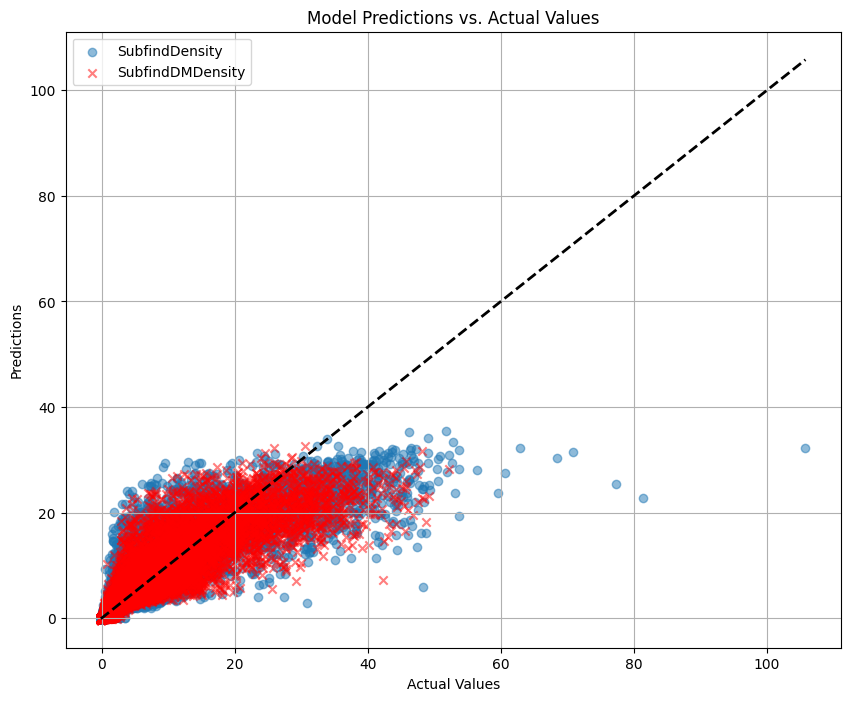

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.scatter(actual_values[:, 0], predictions[:, 0], alpha=0.5, label='SubfindDensity', marker='o')
plt.scatter(actual_values[:, 1], predictions[:, 1], alpha=0.5, color='red', label='SubfindDMDensity', marker='x')

plt.title('Model Predictions vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.legend(loc='upper left')
plt.plot([actual_values.min(), actual_values.max()], [actual_values.min(), actual_values.max()], 'k--', lw=2)
plt.grid(True)
plt.show()
